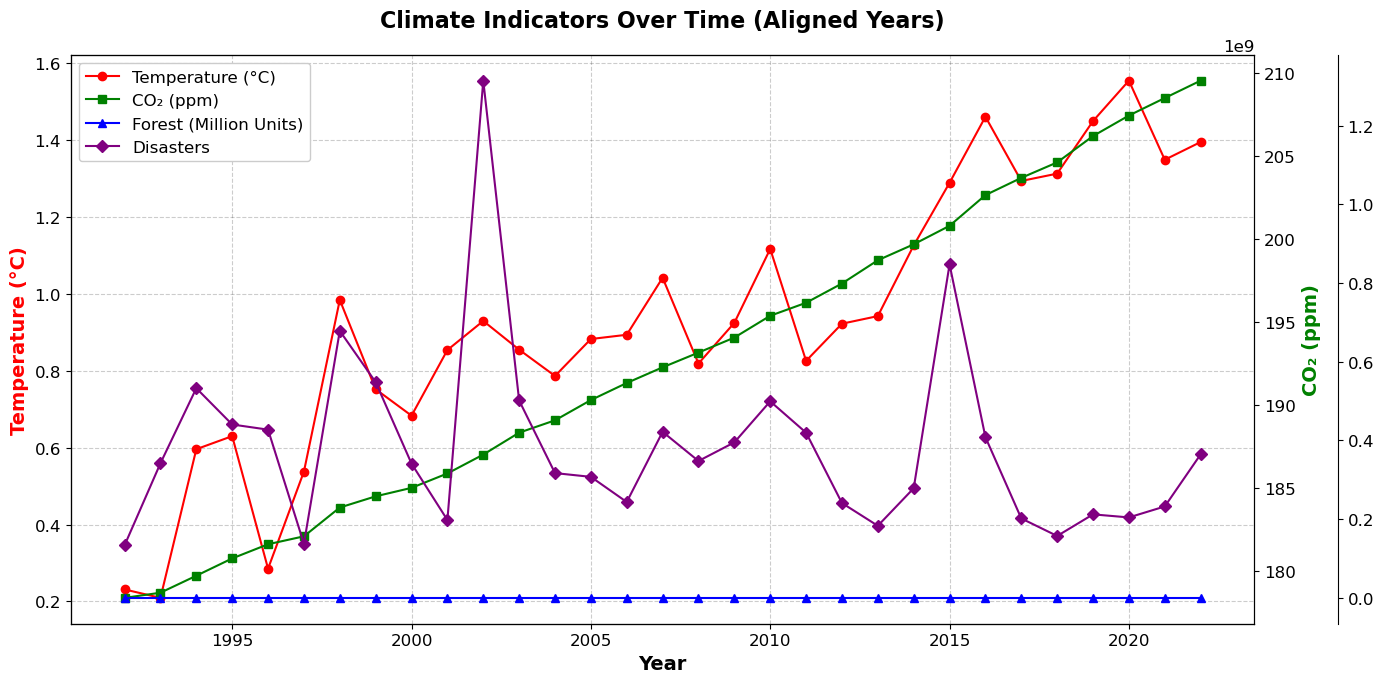

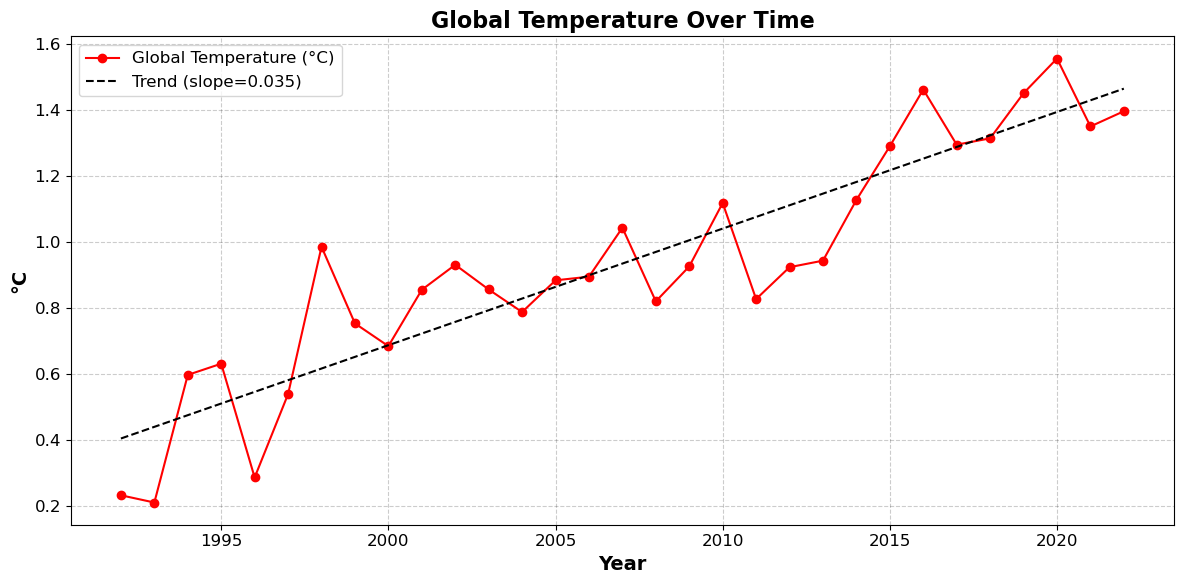

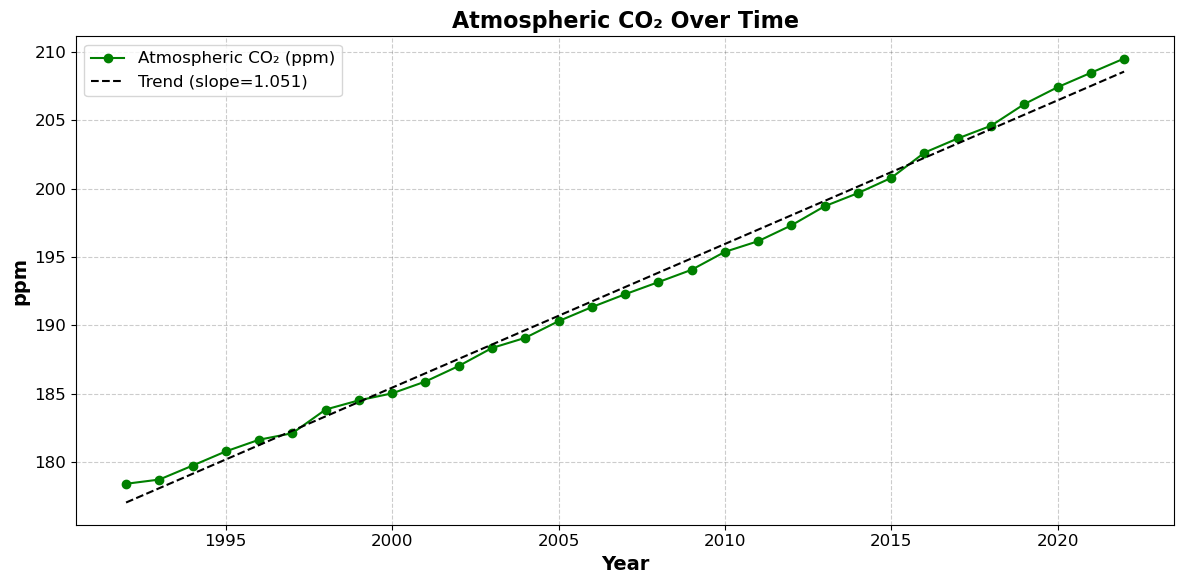

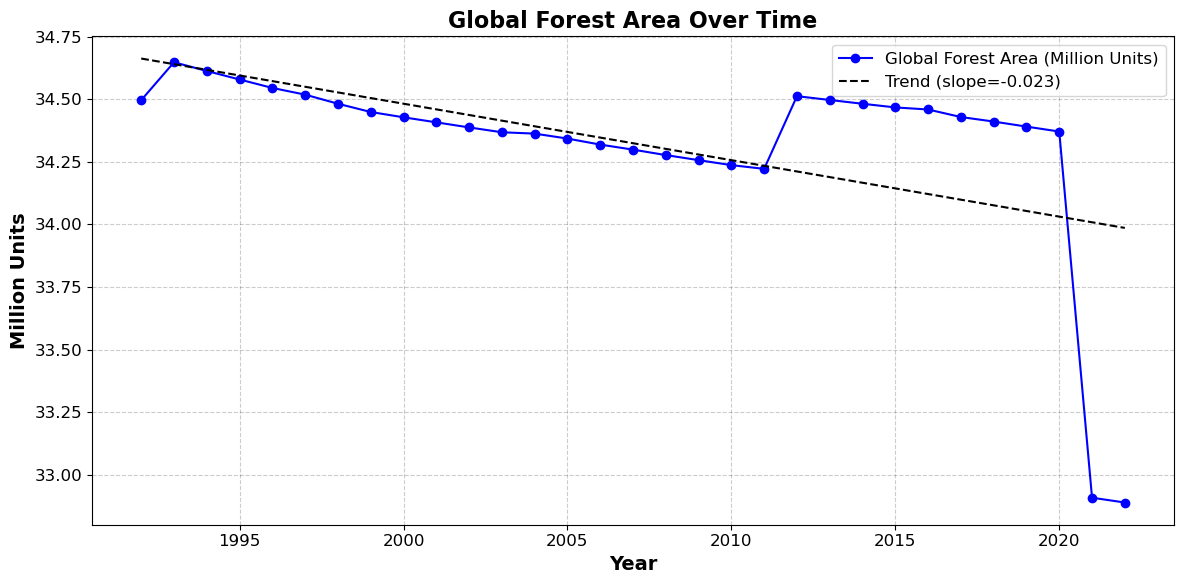

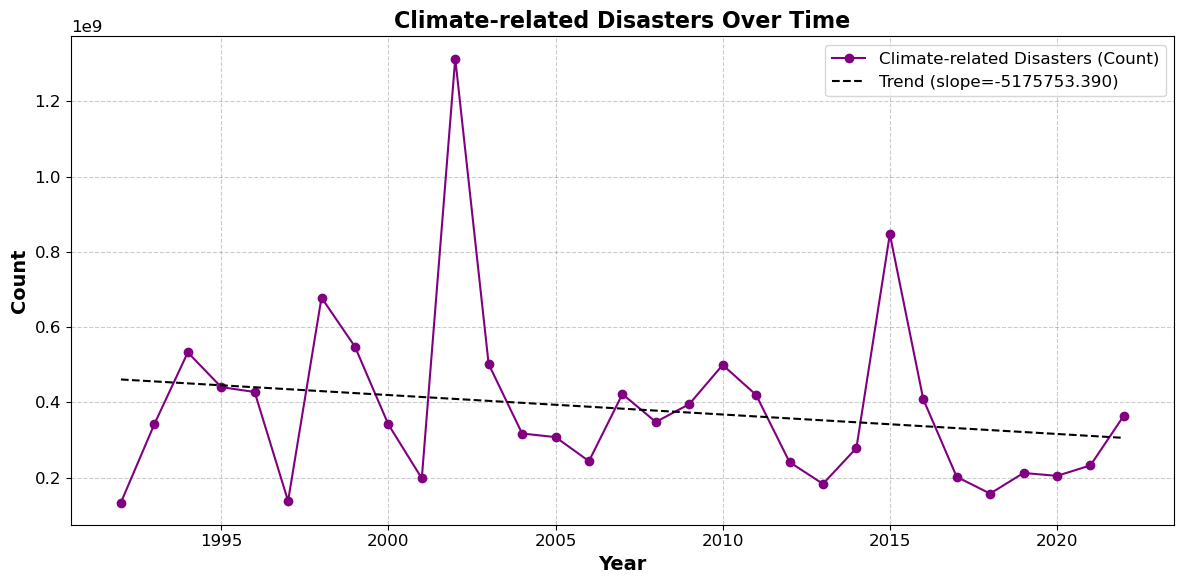

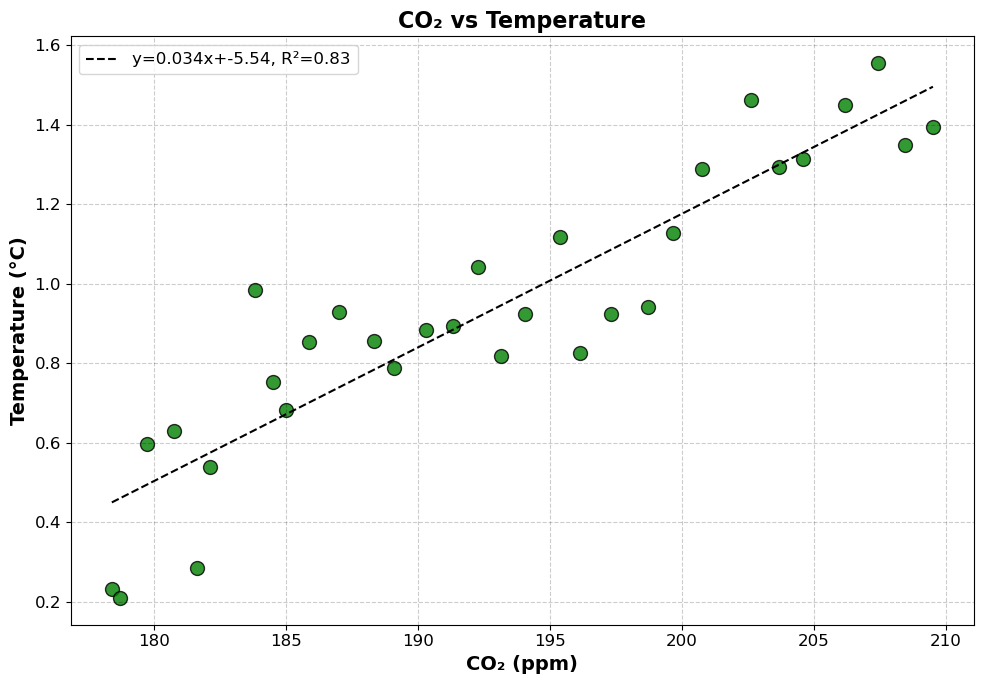

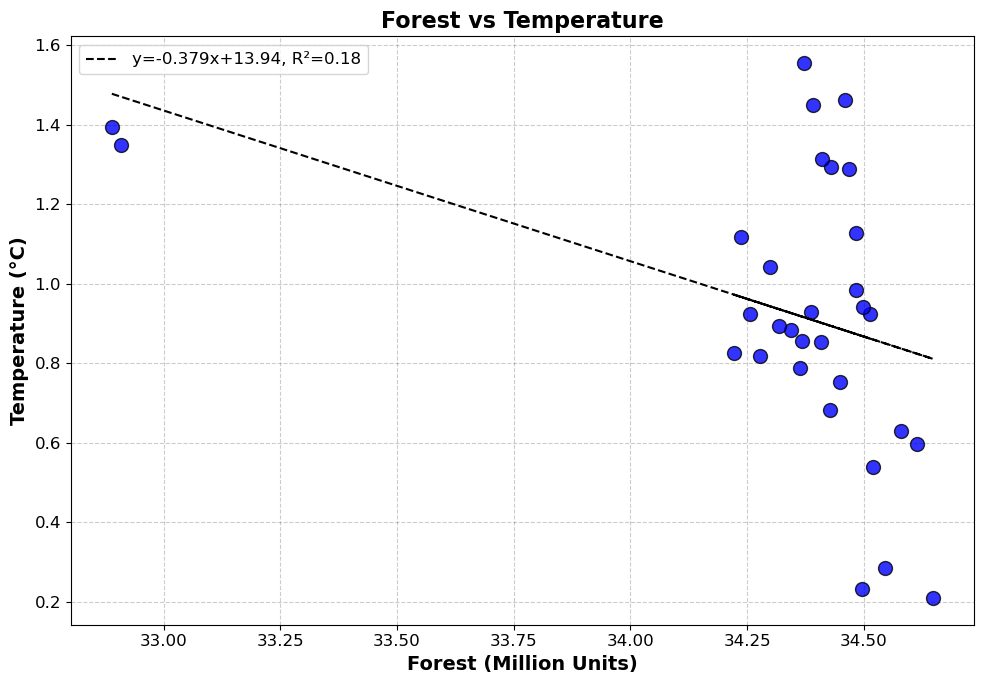

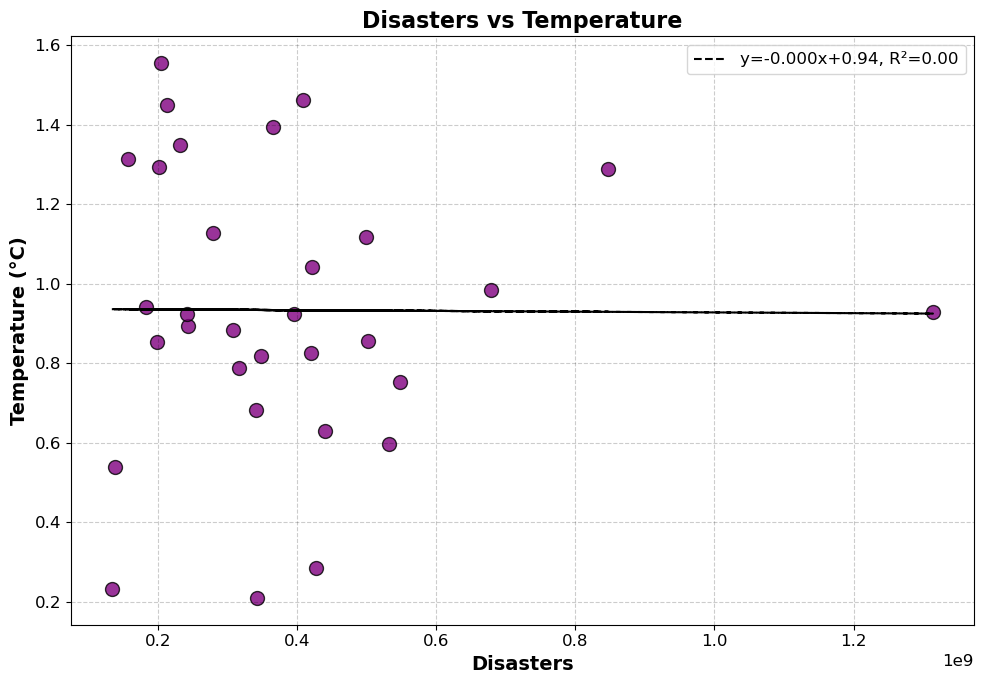

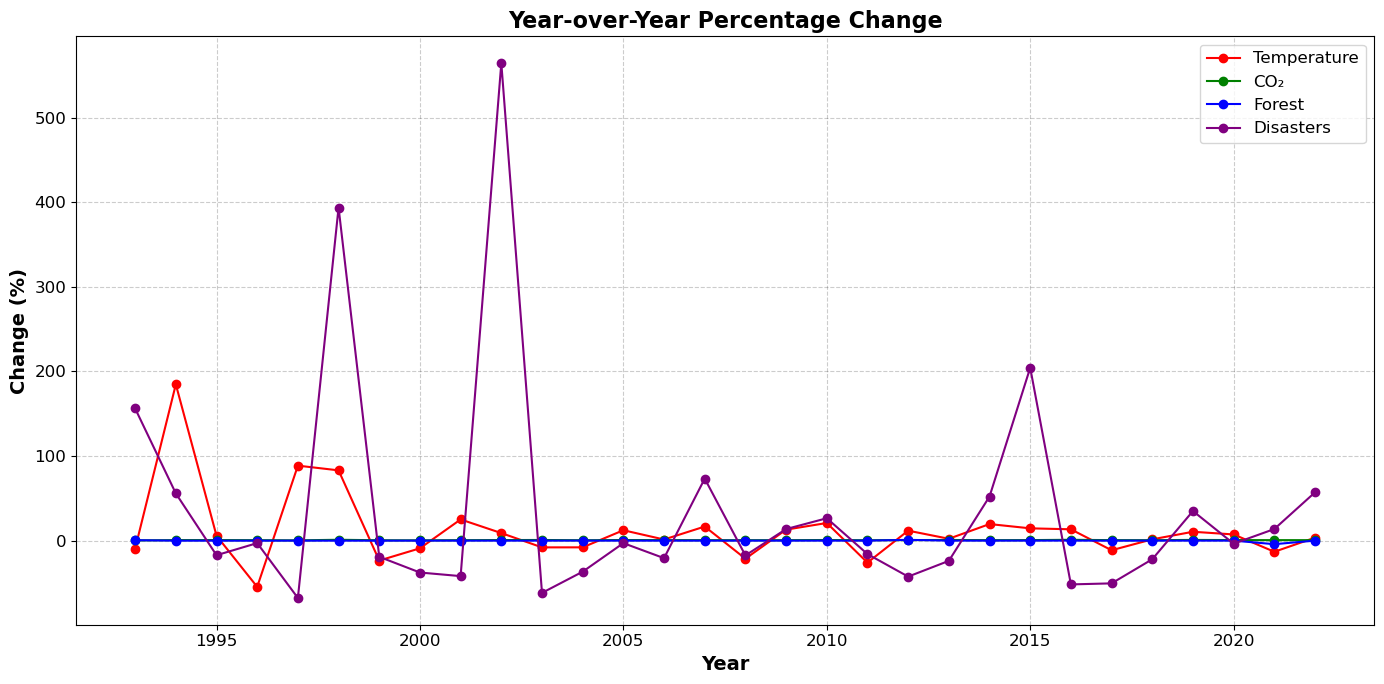

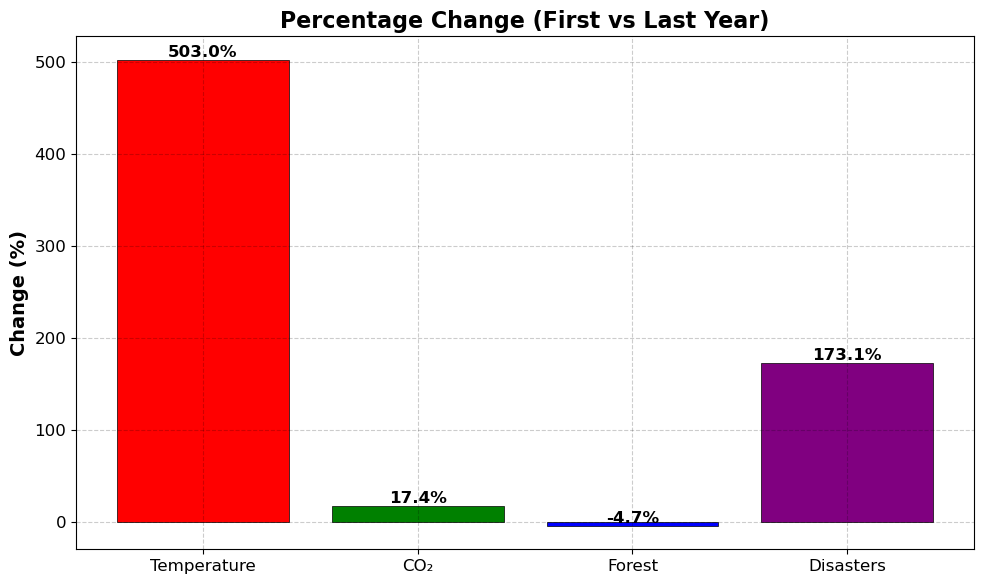

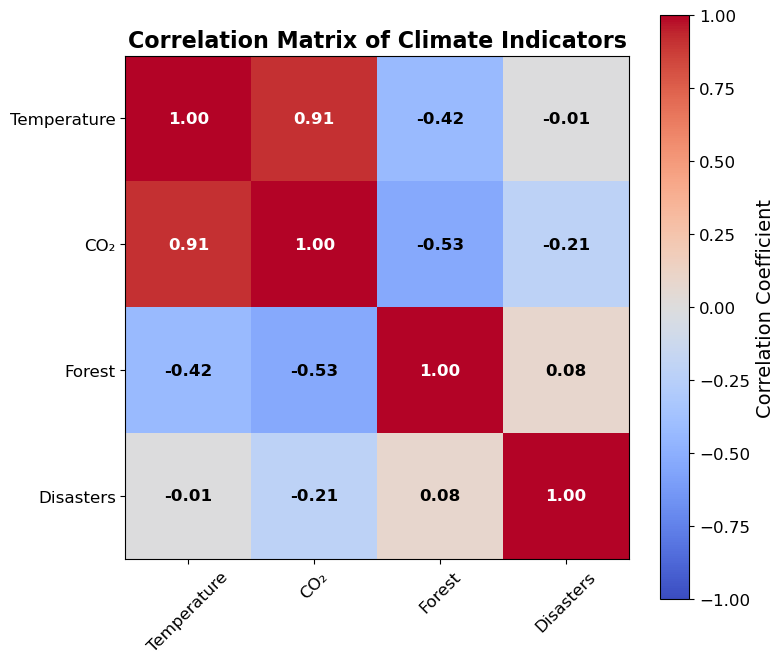

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# ---------------------------
# Helper Function to Read CSV
# ---------------------------
def read_csv(file):
    with open(file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

# ---------------------------
# 1. Temperature Data
# ---------------------------
temp_file = 'Indicator_3_1_Climate_Indicators_Annual_Mean_Global_Surface_Temperature_577579683071085080.csv'
data = read_csv(temp_file)
header, rows = data[0], data[1:]
years_temp = np.array([int(c) for c in header[10:]])
temp_values = []
for row in rows:
    vals = [float(x) if x else np.nan for x in row[10:]]
    temp_values.append(vals)
temp_values = np.array(temp_values)
global_temp = np.nanmean(temp_values, axis=0)

# ---------------------------
# 2. CO₂ Data
# ---------------------------
co2_file = 'Indicator_3_2_Climate_Indicators_Monthly_Atmospheric_Carbon_Dioxide_concentrations_-7117330003911643847.csv'
data = read_csv(co2_file)
header, rows = data[0], data[1:]
dates, values_co2 = [], []
for row in rows:
    try:
        dates.append(row[10])
        values_co2.append(float(row[11]))
    except:
        continue
dates = np.array(dates)
values_co2 = np.array(values_co2)
years_co2 = np.array([int(d[:4]) for d in dates])
unique_years_co2 = np.unique(years_co2)
annual_co2 = np.array([values_co2[years_co2 == y].mean() for y in unique_years_co2])

# ---------------------------
# 3. Forest Data
# ---------------------------
forest_file = 'Forest_and_Carbon.csv'
data = read_csv(forest_file)
header, rows = data[0], data[1:]
year_cols = [c for c in header if c.startswith('F')]
years_forest = np.array([int(c[1:]) for c in year_cols])
forest_vals = []
for row in rows:
    vals = [float(x) if x else np.nan for x in row[-len(year_cols):]]
    forest_vals.append(vals)
forest_vals = np.array(forest_vals)
global_forest = np.nansum(forest_vals, axis=0)

# ---------------------------
# 4. Disaster Data
# ---------------------------
disaster_file = 'Indicator_11_1_Physical_Risks_Climate_related_disasters_frequency_7212563912390016675.csv'
data = read_csv(disaster_file)
header, rows = data[0], data[1:]
year_cols = [c for c in header if c.strip().isdigit()]
years_disasters = np.array([int(c) for c in year_cols])
disaster_vals = []
for row in rows:
    vals = [float(x) if x else np.nan for x in row[-len(year_cols):]]
    disaster_vals.append(vals)
disaster_vals = np.array(disaster_vals)
global_disasters = np.nansum(disaster_vals, axis=0)

# ---------------------------
# 5. Align Common Years
# ---------------------------
common_years = sorted(list(set(years_temp) & set(unique_years_co2) & set(years_forest) & set(years_disasters)))
common_years = np.array(common_years)

def align_data(years, data, common):
    aligned = []
    for y in common:
        if y in years:
            aligned.append(data[list(years).index(y)])
        else:
            aligned.append(np.nan)
    return np.array(aligned)

temp_common = align_data(years_temp, global_temp, common_years)
co2_common = align_data(unique_years_co2, annual_co2, common_years)
forest_common = align_data(years_forest, global_forest, common_years)
disaster_common = align_data(years_disasters, global_disasters, common_years)

# ---------------------------
# 6. Correlation
# ---------------------------
data_matrix = np.vstack([temp_common, co2_common, forest_common, disaster_common])
corr_matrix = np.corrcoef(data_matrix)

# ---------------------------
# Apply Global Styling
# ---------------------------
plt.style.use('default')
plt.rcParams.update({
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': 'black',
    'grid.alpha': 0.2,
    'grid.linestyle': '--',
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

def apply_grid():
    plt.grid(True, color='black', alpha=0.2, linestyle='--', linewidth=0.8)

# ---------------------------
# 7. Visualizations (Improved)
# ---------------------------

# ---------------------------
# 1. Combined Trend (All Indicators)
# ---------------------------
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Year', fontweight='bold')
ax1.set_ylabel('Temperature (°C)', color='red', fontweight='bold')
l1 = ax1.plot(common_years, temp_common, color='red', label='Temperature (°C)', linewidth=1.5, marker='o')
apply_grid()

ax2 = ax1.twinx()
l2 = ax2.plot(common_years, co2_common, color='green', label='CO₂ (ppm)', linewidth=1.5, marker='s')
ax2.set_ylabel('CO₂ (ppm)', color='green', fontweight='bold')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
l3 = ax3.plot(common_years, forest_common/1e6, color='blue', label='Forest (Million Units)', linewidth=1.5, marker='^')
l4 = ax3.plot(common_years, disaster_common, color='purple', label='Disasters', linewidth=1.5, marker='D')

lines = l1 + l2 + l3 + l4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', framealpha=1)

plt.title("Climate Indicators Over Time (Aligned Years)", fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ---------------------------
# 2-5. Individual Trends
# ---------------------------
indicators = [
    (temp_common, 'Global Temperature', '°C', 'red'),
    (co2_common, 'Atmospheric CO₂', 'ppm', 'green'),
    (forest_common/1e6, 'Global Forest Area', 'Million Units', 'blue'),
    (disaster_common, 'Climate-related Disasters', 'Count', 'purple')
]

for data, title, unit, color in indicators:
    plt.figure(figsize=(12, 6))
    plt.plot(common_years, data, color=color, marker='o', linewidth=1.5, label=f"{title} ({unit})")
    
    # Add trend line
    mask = ~np.isnan(data)
    if np.sum(mask) > 1:
        coeffs = np.polyfit(common_years[mask], data[mask], 1)
        plt.plot(common_years[mask], coeffs[1] + coeffs[0]*common_years[mask],
                 '--', color='black', linewidth=1.5,
                 label=f"Trend (slope={coeffs[0]:.3f})")
    
    plt.title(f"{title} Over Time", fontweight='bold')
    plt.xlabel('Year', fontweight='bold')
    plt.ylabel(unit, fontweight='bold')
    apply_grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------
# 6-8. Scatter Plots (with Regression)
# ---------------------------
pairs = [
    (co2_common, temp_common, 'CO₂ vs Temperature', 'CO₂ (ppm)', 'Temperature (°C)', 'green'),
    (forest_common/1e6, temp_common, 'Forest vs Temperature', 'Forest (Million Units)', 'Temperature (°C)', 'blue'),
    (disaster_common, temp_common, 'Disasters vs Temperature', 'Disasters', 'Temperature (°C)', 'purple')
]

for x, y, title, xlabel, ylabel, color in pairs:
    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, s=100, color=color, edgecolor='black', alpha=0.8)
    
    # Add regression line
    mask = ~np.isnan(x) & ~np.isnan(y)
    coeffs = np.polyfit(x[mask], y[mask], 1)
    plt.plot(x[mask], coeffs[1] + coeffs[0]*x[mask],
             '--', color='black', linewidth=1.5,
             label=f"y={coeffs[0]:.3f}x+{coeffs[1]:.2f}, R²={np.corrcoef(x[mask], y[mask])[0,1]**2:.2f}")
    
    plt.title(title, fontweight='bold')
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    apply_grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------
# 9. Year-over-Year % Change
# ---------------------------
changes = {
    'Temperature': np.diff(temp_common)/temp_common[:-1]*100,
    'CO₂': np.diff(co2_common)/co2_common[:-1]*100,
    'Forest': np.diff(forest_common)/forest_common[:-1]*100,
    'Disasters': np.diff(disaster_common)/disaster_common[:-1]*100
}

plt.figure(figsize=(14, 7))
colors = ['red', 'green', 'blue', 'purple']
for (label, change), color in zip(changes.items(), colors):
    plt.plot(common_years[1:], change, marker='o', linewidth=1.5, label=label, color=color)

plt.title("Year-over-Year Percentage Change", fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Change (%)', fontweight='bold')
apply_grid()
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# 10. Percentage Change (First vs Last Year)
# ---------------------------
first_vals = np.array([temp_common[0], co2_common[0], forest_common[0], disaster_common[0]])
last_vals = np.array([temp_common[-1], co2_common[-1], forest_common[-1], disaster_common[-1]])
pct_change_first_last = ((last_vals - first_vals) / first_vals) * 100
labels = ['Temperature', 'CO₂', 'Forest', 'Disasters']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, pct_change_first_last,
               color=['red', 'green', 'blue', 'purple'],
               edgecolor='black', linewidth=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.title("Percentage Change (First vs Last Year)", fontweight='bold')
plt.ylabel('Change (%)', fontweight='bold')
apply_grid()
plt.tight_layout()
plt.show()

# ---------------------------
# 11. Correlation Heatmap
# ---------------------------
plt.figure(figsize=(8, 7))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

for i in range(4):
    for j in range(4):
        color = 'white' if abs(corr_matrix[i,j]) > 0.7 else 'black'
        plt.text(j, i, f"{corr_matrix[i,j]:.2f}", ha='center', va='center', color=color, fontweight='bold')

plt.colorbar(im, label="Correlation Coefficient")
plt.xticks(range(4), ['Temperature', 'CO₂', 'Forest', 'Disasters'], rotation=45)
plt.yticks(range(4), ['Temperature', 'CO₂', 'Forest', 'Disasters'])
plt.title("Correlation Matrix of Climate Indicators", fontweight='bold')
plt.tight_layout()
plt.show()